# 1. Установка библиотек

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!mamba install -c conda-forge rdkit chembl_structure_pipeline



                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['rdkit', 'chembl_structure_pipeline']

conda-forge/linux-64     Using cache
conda-forge/noarch     

In [ ]:
!git clone https://github.com/DSPsleeporg/smiles-transformer.git

fatal: destination path 'smiles-transformer' already exists and is not an empty directory.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import DrawingOptions

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import NearestNeighbors

sys.path.append('./smiles-transformer/smiles_transformer')

import torch
from pretrain_trfm import TrfmSeq2seq
from build_vocab import WordVocab
from utils import split


from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc 

Была преподготовка, закачиваем данные

In [ ]:
# Загружаем словарь символы-номера символов
!wget https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/vocab.pkl

--2021-05-09 19:47:23--  https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/vocab.pkl
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/vocab.pkl [following]
--2021-05-09 19:47:23--  https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/vocab.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1723 (1.7K) [application/octet-stream]
Saving to: ‘vocab.pkl.3’

vocab.pkl.3         100%[===================>]   1.68K  --.-KB/s    in 0s      

2021-05-09 19:47:23 (29.6 MB/s) - ‘vocab.pkl.3’ saved [1723/1723]



In [ ]:
# загрузим веса предобученной модели
!wget https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/weights_trfm.pkl

--2021-05-09 19:47:23--  https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/weights_trfm.pkl
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/weights_trfm.pkl [following]
--2021-05-09 19:47:23--  https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/weights_trfm.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22128521 (21M) [application/octet-stream]
Saving to: ‘weights_trfm.pkl.3’

weights_trfm.pkl.3  100%[===================>]  21.10M  51.0MB/s    in 0.4s    

2021-05-09 19:47:24 (51.0 MB/s) - ‘w

In [ ]:
pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

In [ ]:
vocab = WordVocab.load_vocab('vocab.pkl')

# 2. Функции, трансформеры

In [ ]:
trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4) 
trfm.load_state_dict(torch.load("weights_trfm.pkl", map_location=torch.device('cpu')))
trfm.eval()
print('Total parameters:', sum(p.numel() for p in trfm.parameters()))

Total parameters: 4245037


In [ ]:
# Функция принимает на вход один SMILES, укорачивает их
# При помощи словаря переводит символы в набор цифр
# Возвращает массив чисел
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids) 
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids

# Функция принимает на вход набор SMILES
# И применяет функцию get_inputs()
def get_array(smiles):
    x_id = []
    for sm in smiles:
        a = get_inputs(sm)
        x_id.append(a)
        
    return torch.tensor(x_id)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = torch.tensor(X_data)
        self.y_data = torch.tensor(y_data)

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, indexes):
        if torch.is_tensor(indexes):
            indexes = indexes.tolist()
        predict = self.X_data[indexes, :]
        ans = self.y_data[indexes]
        return predict, ans

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0, verbose=False, path='/content/drive/MyDrive/HSE_data/strong_model.pt'):
        from google.colab import drive
        drive.mount('/content/drive')
        
        self.patience = patience
        self.delta = delta
        self.stop = False
        self.verbose = verbose #wtf
        self.path = path
        self.best_score = None
        self.best_model = None
        self.counter = 0
        self.epoch = 0

    def __call__(self, val_loss, model, epoch = 0):
        if (self.best_score == None or self.best_score - self.delta > val_loss): #less loss - better
            self.best_score = val_loss
            self.best_model = model
            self.counter = 0
            self.epoch = epoch
        elif (self.best_score - self.delta < val_loss): #should I write this statement?
            self.counter += 1
            if (self.counter > self.patience):
                self.save_model()
                self.stop = True

    
    def save_model(self):
        torch.save(self.best_model, self.path)

In [ ]:
import torch.nn as nn
class my_damn_net(nn.Module):
    def __init__(self, num_features = 1024, drop_prob = 0.5):
        super().__init__()
        self.input_layer = nn.Linear(num_features, 512)
        
        #что можно сделать с слоем релу
        self.second_layer = nn.Linear(512, 256)
        self.third_layer = nn.Linear(256, 128)
        self.ans = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        

    def forward(self, x): #wtf is x
        x = F.relu(self.input_layer(x))
        self.dropout(x)

        x = F.relu(self.second_layer(x))
        self.dropout(x)

        x = F.relu(self.third_layer(x))
        self.dropout(x)

        x = self.ans(x)

        return x

In [ ]:
import torch.optim as optim
    
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# 3. Обработка ESOL (растворимость в воде)

In [ ]:
!wget https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/esol.csv

--2021-05-09 19:47:24--  https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/esol.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/esol.csv [following]
--2021-05-09 19:47:24--  https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/esol.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘esol.csv.2’

esol.csv.2          100%[===================>]  94.43K  --.-KB/s    in 0.01s   

2021-05-09 19:47:24 (6.44 MB/s) - ‘esol.csv.2’ saved [96699/96699]



In [ ]:
data = pd.read_csv('esol.csv')

In [ ]:
from multiprocessing import Pool
with Pool(10) as pool:
    x_split = pool.map(split, data.smiles) 
xid = get_array(x_split)

In [ ]:
X_esol = trfm.encode(torch.t(xid))
y_esol = data['measured log solubility in mols per litre']
print(X_esol.shape)

There are 1128 molecules. It will take a little time.
(1128, 1024)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_esol, y_esol, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)
trainset = MyDataset(X_train, y_train.values)
validset = MyDataset(X_valid, y_valid.values)

batch_size = 60
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) #already shuffled
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)


In [ ]:
validset[0]

(tensor([ 0.0640,  0.0149,  0.2818,  ...,  0.4324,  0.0027, -0.1128]),
 tensor(-3.1000, dtype=torch.float64))

In [ ]:
j = 0
for feat, ans in validloader:
    print(feat)
    print(ans)
    print(type(feat), type(ans))
    print()
    j += 1

    if j == 2:
        break

tensor([[ 6.3982e-02,  1.4949e-02,  2.8181e-01,  ...,  4.3241e-01,
          2.6571e-03, -1.1278e-01],
        [ 9.1348e-02,  3.7658e-01,  1.2822e-01,  ...,  1.0216e+00,
          8.5062e-01,  1.1116e+00],
        [ 1.9781e-01,  3.6786e-01,  3.7407e-01,  ...,  9.4718e-01,
          1.0744e+00,  1.2071e+00],
        ...,
        [ 1.2706e-01,  2.8139e-01,  2.6762e-01,  ...,  1.2405e+00,
          1.0430e+00,  8.3476e-01],
        [ 7.9611e-02,  1.1679e-03,  5.0510e-01,  ...,  1.1728e-01,
          4.4676e-01,  6.5926e-02],
        [ 1.6750e-01, -7.4661e-02,  2.7782e-01,  ...,  6.3189e-01,
          7.7741e-01,  4.3164e-01]])
tensor([-3.1000, -1.8860, -8.4000, -4.6400, -2.0600, -8.0570, -5.7200, -2.6760,
        -3.6900, -1.3000, -3.0830, -4.3000, -2.9400, -2.3560, -2.1900, -1.2900,
        -2.6300, -0.9200, -2.5640, -1.7200, -2.7300, -0.1400, -1.0900, -3.1200,
        -3.1500, -4.5300, -4.3600, -2.8900, -2.1700, -0.8200, -6.3400, -1.8500,
        -3.1800, -0.8500, -2.3900, -0.1700, -0.7

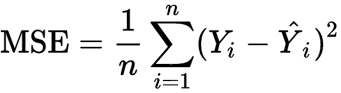


In [ ]:
y_test.values

array([-2.54 , -2.253, -2.484, -2.54 , -7.2  , -1.19 , -4.314, -2.19 ,
       -7.66 , -2.57 , -4.42 ,  0.54 , -3.4  , -2.18 , -3.38 , -1.92 ,
       -2.05 , -8.334, -4.37 , -3.76 , -1.84 , -6.35 ,  0.7  , -1.57 ,
       -0.74 , -7.21 , -0.49 , -0.63 , -1.23 , -1.9  , -1.34 , -6.726,
       -3.74 , -1.55 , -2.55 , -2.58 , -4.56 ,  0.   , -4.02 , -6.876,
       -1.17 , -8.017, -4.207, -5.68 , -7.8  , -4.72 , -4.95 , -4.02 ,
       -5.05 , -8.003, -5.08 , -7.92 , -1.52 , -1.99 , -1.17 , -4.749,
       -1.63 , -3.09 , -3.   , -6.291, -2.17 , -2.322, -0.04 , -5.736,
       -4.114, -1.13 , -2.13 , -3.96 , -2.35 , -2.084, -0.29 ,  0.76 ,
       -2.21 , -3.931, -2.878, -0.59 , -1.98 , -4.576, -4.755, -5.64 ,
       -4.62 , -1.68 , -3.01 , -4.046, -5.06 , -1.38 , -2.64 , -0.12 ,
       -6.62 , -0.4  , -3.083, -3.59 , -4.63 , -1.04 , -1.75 , -5.43 ,
       -0.96 ,  1.07 , -1.78 , -0.41 , -1.74 , -2.68 , -5.84 , -3.19 ,
       -1.25 , -3.451,  1.144, -0.8  , -5.071, -7.321, -7.85 , -1.22 ,
      

In [ ]:
def valid_calculat(model, validloader):
    true_val = []
    pred_val = []

    with torch.no_grad():
        for feat, ans in validloader:
            feat = feat.to(device)

            output = model(feat).float()
            output = output.flatten()
            true_val += list(ans.cpu().numpy())
            pred_val += list(output.cpu().numpy())

    return mean_squared_error(true_val, pred_val)

def test_calculat(model, X_test, y_test):
    with torch.no_grad():
        X_test = X_test.to(device)
        output = model(X_test)
        output = output.flatten()
        output = list(output.cpu().numpy())
    
    plt.hist(output, alpha=0.5)
    plt.hist(y_test, alpha=0.5)
    from scipy.stats import mannwhitneyu
    print(mannwhitneyu(output, y_test))

    return mean_squared_error(y_test, output), r2_score(y_test, output)

In [ ]:
import torch.nn.functional as F
# Создаем новую модель
model = my_damn_net()

model = model.to(device)


# Loss функция и оптимизатор будут необходимы при обучении.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 
                    lr=0.001
                    )

ctrl = EarlyStopping()

from tqdm import tqdm

epoch = 0
valid_loss = []
train_loss = []

while not ctrl.stop:
    running_loss = 0

    for feat, ans in tqdm(trainloader):
        feat = feat.to(device)
        ans = ans.float()
        ans = ans.to(device)
        optimizer.zero_grad() #обнуление градиента
        
        output = model(feat).float()
        
        loss = criterion(output, ans)

        loss.backward() #вычисление градиента

        optimizer.step() #обучение нейронки

        running_loss += loss.item()

    loss = valid_calculat(model, validloader)
    valid_loss.append(loss)

    ctrl(loss, model)

    train_loss.append(running_loss / len(trainloader))

    print(f"Epoch {epoch} - training loss: {train_loss[-1]}")
    print(f"Epoch {epoch} - validation loss: {loss}")
    print()

    epoch += 1

    if epoch == 150:
        break



  0%|          | 0/16 [00:00<?, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 94%|█████████▍| 15/16 [00:00<00:00, 70.22it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due 

Epoch 0 - training loss: 5.59193129837513
Epoch 0 - validation loss: 4.266020443557263



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 80.76it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due t

Epoch 1 - training loss: 4.3644032925367355
Epoch 1 - validation loss: 4.340349775888963




  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 75.37it/s]

Epoch 2 - training loss: 4.330246135592461
Epoch 2 - validation loss: 4.28634136483443



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 75.53it/s]

Epoch 3 - training loss: 4.2804266810417175
Epoch 3 - validation loss: 4.184385181770972



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 77.37it/s]

Epoch 4 - training loss: 4.2749544233083725
Epoch 4 - validation loss: 4.166638733228969



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 78.93it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due t

Epoch 5 - training loss: 4.2762007266283035
Epoch 5 - validation loss: 4.136177528962204



  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 83.18it/s]

Epoch 6 - training loss: 4.272820383310318
Epoch 6 - validation loss: 4.119941338246396



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 77.90it/s]

Epoch 7 - training loss: 4.271808415651321
Epoch 7 - validation loss: 4.105396365872966



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 44%|████▍     | 7/16 [00:00<00:00, 68.83it/s]

Epoch 8 - training loss: 4.270368814468384
Epoch 8 - validation loss: 4.091189589512256



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 81.97it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due t

Epoch 9 - training loss: 4.269341617822647
Epoch 9 - validation loss: 4.079298671332769




  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 85.41it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 16/16 [00:00<00:00, 84.83it/s]

Epoch 10 - training loss: 4.268050029873848
Epoch 10 - validation loss: 4.073142893835277




  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 78.97it/s]

Epoch 11 - training loss: 4.267103850841522
Epoch 11 - validation loss: 4.058887922674029



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 82.49it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due t

Epoch 12 - training loss: 4.265834733843803
Epoch 12 - validation loss: 4.057017596948353




  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 78.94it/s]

Epoch 13 - training loss: 4.265105217695236
Epoch 13 - validation loss: 4.0463431723203565



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 74.93it/s]

Epoch 14 - training loss: 4.26388344168663
Epoch 14 - validation loss: 4.0453125303616675



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 72.72it/s]

Epoch 15 - training loss: 4.263232633471489
Epoch 15 - validation loss: 4.038884978699874



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 81.13it/s]

Epoch 16 - training loss: 4.262189477682114
Epoch 16 - validation loss: 4.033578623088578



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 76.37it/s]

Epoch 17 - training loss: 4.26130536198616
Epoch 17 - validation loss: 4.030307334192108



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 80.94it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due t

Epoch 18 - training loss: 4.260319873690605
Epoch 18 - validation loss: 4.031239588201988




  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 79.79it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 16/16 [00:00<00:00, 82.44it/s]

Epoch 19 - training loss: 4.259416401386261
Epoch 19 - validation loss: 4.024951231236835




  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 82.81it/s]

Epoch 20 - training loss: 4.258546516299248
Epoch 20 - validation loss: 4.031437136811836



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 83.88it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due t

Epoch 21 - training loss: 4.2576023042202
Epoch 21 - validation loss: 4.015284099150196



  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 73.92it/s]

Epoch 22 - training loss: 4.256709560751915
Epoch 22 - validation loss: 4.036063449334428



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 76.57it/s]

Epoch 23 - training loss: 4.2564234137535095
Epoch 23 - validation loss: 4.009668035035917



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 80.43it/s]

Epoch 24 - training loss: 4.25499914586544
Epoch 24 - validation loss: 4.030539814394558



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 83.04it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due t

Epoch 25 - training loss: 4.255066618323326
Epoch 25 - validation loss: 4.015609693512221




  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 77.84it/s]

Epoch 26 - training loss: 4.25359907746315
Epoch 26 - validation loss: 4.02316624470932



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 74.07it/s]

Epoch 27 - training loss: 4.253237992525101
Epoch 27 - validation loss: 3.9989712901495955



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 73.81it/s]

Epoch 28 - training loss: 4.252439007163048
Epoch 28 - validation loss: 4.02508664865256



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 78.60it/s]

Epoch 29 - training loss: 4.2519675344228745
Epoch 29 - validation loss: 4.006410613199964



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 84.62it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due t

Epoch 30 - training loss: 4.250926226377487
Epoch 30 - validation loss: 4.0277591982906875




  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 79.18it/s]

Epoch 31 - training loss: 4.250761225819588
Epoch 31 - validation loss: 4.020655446272497



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 77.98it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due t

Epoch 32 - training loss: 4.249837875366211
Epoch 32 - validation loss: 4.029354744476069




  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 82.76it/s]

Epoch 33 - training loss: 4.2494455724954605
Epoch 33 - validation loss: 4.012084373788314



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 77.76it/s]

Epoch 34 - training loss: 4.248612076044083
Epoch 34 - validation loss: 4.037456809352396



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 80.26it/s]

Epoch 35 - training loss: 4.248863682150841
Epoch 35 - validation loss: 3.9864032813348267



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 82.57it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due t

Epoch 36 - training loss: 4.2473242580890656
Epoch 36 - validation loss: 4.0262182088909695




  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 8/16 [00:00<00:00, 74.61it/s]

Epoch 37 - training loss: 4.247123524546623
Epoch 37 - validation loss: 4.012149769014522



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▋    | 9/16 [00:00<00:00, 85.35it/s]

Epoch 38 - training loss: 4.246146738529205
Epoch 38 - validation loss: 4.042834645968947



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 44%|████▍     | 7/16 [00:00<00:00, 69.51it/s]

Epoch 39 - training loss: 4.245977655053139
Epoch 39 - validation loss: 4.012602080762318



 94%|█████████▍| 15/16 [00:00<00:00, 68.42it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 44%|████▍     | 7/16 [00:00<00:00, 63.74it/s]

Epoch 40 - training loss: 4.245220839977264
Epoch 40 - validation loss: 4.03577645925448



 88%|████████▊ | 14/16 [00:00<00:00, 60.68it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 38%|███▊      | 6/16 [00:00<00:00, 54.11it/s]

Epoch 41 - training loss: 4.245073094964027
Epoch 41 - validation loss: 4.016504622008465



 75%|███████▌  | 12/16 [00:00<00:00, 52.06it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 31%|███▏      | 5/16 [00:00<00:00, 49.16it/s]

Epoch 42 - training loss: 4.244043305516243
Epoch 42 - validation loss: 4.0557390870691465



 94%|█████████▍| 15/16 [00:00<00:00, 46.79it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 16/16 [00:00<00:00, 46.55it/s]


Epoch 43 - training loss: 4.243978783488274
Epoch 43 - validation loss: 4.014083628303162



In [ ]:
from matplotlib.pyplot import figure
def plot_train_valid_loss(train_loss, valid_loss):
    fig, ax = plt.subplots(figsize = (8, 13))
    ax.plot(train_loss, label="train_loss")
    ax.plot(valid_loss, label="valid_loss")
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    # fig = plt.figure(figsize=(20, 15), dpi=100)
    plt.show()

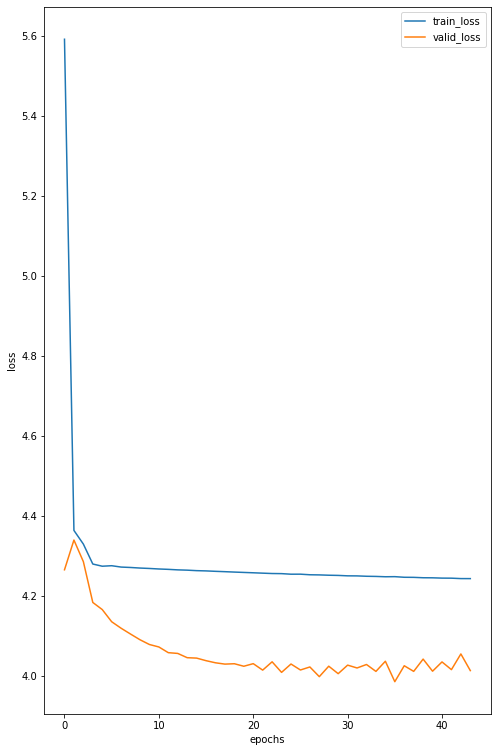

In [ ]:

plot_train_valid_loss(train_loss, valid_loss)

Loss для Validation я считал с помощью метрик в r2kit. Эпох более 50. Когда я считал loss для validation и ставил EarlyStopping с помощью criterion, то эпох < 20


In [ ]:
ctrl.__dict__

{'best_model': my_damn_net(
   (input_layer): Linear(in_features=1024, out_features=512, bias=True)
   (second_layer): Linear(in_features=512, out_features=256, bias=True)
   (third_layer): Linear(in_features=256, out_features=128, bias=True)
   (ans): Linear(in_features=128, out_features=1, bias=True)
   (dropout): Dropout(p=0.5, inplace=False)
 ),
 'best_score': 3.9864032813348267,
 'counter': 8,
 'delta': 0,
 'epoch': 0,
 'path': '/content/drive/MyDrive/HSE_data/fucking_model.pt',
 'patience': 7,
 'stop': True,
 'verbose': False}

MannwhitneyuResult(statistic=6227.0, pvalue=0.37469366833537554)


(5.226565246542069, 9.759786035690166e-05)

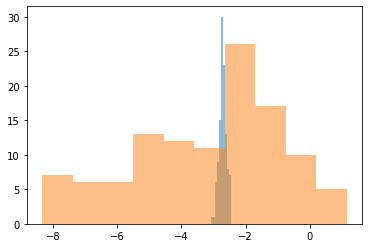

In [ ]:
test_calculat(model, torch.tensor(X_test), y_test.values)

**MSE = 5.23, R2 = 0.0001 для тестового сета esol из 10% молекул датасета**



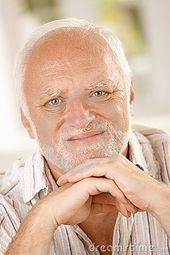


Критерий Манна-Уитни говорит, что данные выборки были выбраны из одной генеральной совокупности, p = 0.08 (p >= 0.05)


# 4. Обработка Lipophilicity (растворимость в жирах)

In [ ]:
!wget https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/lipophilicity.csv

--2021-05-09 19:48:04--  https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/lipophilicity.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/lipophilicity.csv [following]
--2021-05-09 19:48:04--  https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/lipophilicity.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282606 (276K) [text/plain]
Saving to: ‘lipophilicity.csv’

lipophilicity.csv   100%[===================>] 275.98K  --.-KB/s    in 0.03s   

2021-05-09 19:48:05 (8.78 MB/s) - ‘lipophilicity.

In [ ]:
data_lip = pd.read_csv('lipophilicity.csv')
x_split_lip = data_lip.smiles.apply(split)
xid_lip = get_array(x_split_lip)

SMILES is too long (251)
SMILES is too long (267)


In [ ]:
X_lip = trfm.encode(torch.t(xid_lip))
print(X_lip.shape)

There are 4200 molecules. It will take a little time.
(4200, 1024)


In [ ]:
y_lip = data_lip['exp']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_lip, y_lip, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)
trainset = MyDataset(X_train, y_train.values)
validset = MyDataset(X_valid, y_valid.values)

batch_size = 60
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) #already shuffled
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)

In [ ]:

# Создаем новую модель
model = my_damn_net()

model = model.to(device)


# Loss функция и оптимизатор будут необходимы при обучении.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 
                    lr=0.001
                    )

ctrl = EarlyStopping()

from tqdm import tqdm

epoch = 0
valid_loss = []
train_loss = []

while not ctrl.stop:
    running_loss = 0

    for feat, ans in tqdm(trainloader):
        feat = feat.to(device)
        ans = ans.float()
        ans = ans.to(device)
        optimizer.zero_grad() #обнуление градиента
        
        output = model(feat).float()
        
        loss = criterion(output, ans)

        loss.backward() #вычисление градиента

        optimizer.step() #обучение нейронки

        running_loss += loss.item()

    loss = valid_calculat(model, validloader)
    valid_loss.append(loss)

    ctrl(loss, model)

    train_loss.append(running_loss / len(trainloader))

    print(f"Epoch {epoch} - training loss: {train_loss[-1]}")
    print(f"Epoch {epoch} - validation loss: {loss}")
    print()

    epoch += 1

    if epoch == 150:
        break



  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 46.74it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 96%|█████████▋| 55/57 [00:01<00:00, 43.40it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 43.30it/s]

Epoch 0 - training loss: 1.7468242038760269
Epoch 0 - validation loss: 1.3974595539200625



 96%|█████████▋| 55/57 [00:01<00:00, 45.10it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 42.34it/s]

Epoch 1 - training loss: 1.5003292529206527
Epoch 1 - validation loss: 1.392094745048225



 96%|█████████▋| 55/57 [00:01<00:00, 46.73it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 44.36it/s]

Epoch 2 - training loss: 1.5021142760912578
Epoch 2 - validation loss: 1.3878657915925907



 96%|█████████▋| 55/57 [00:01<00:00, 44.89it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 45.26it/s]

Epoch 3 - training loss: 1.4972153326921296
Epoch 3 - validation loss: 1.3837664759179693



 96%|█████████▋| 55/57 [00:01<00:00, 46.69it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 47.00it/s]

Epoch 4 - training loss: 1.4924237330754597
Epoch 4 - validation loss: 1.3818107498758103



 96%|█████████▋| 55/57 [00:01<00:00, 47.03it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 46.41it/s]

Epoch 5 - training loss: 1.488727066600532
Epoch 5 - validation loss: 1.3820079951184125



 96%|█████████▋| 55/57 [00:01<00:00, 46.82it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 47.14it/s]

Epoch 6 - training loss: 1.48566234320925
Epoch 6 - validation loss: 1.3837954582967051



 96%|█████████▋| 55/57 [00:01<00:00, 47.46it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 46.84it/s]

Epoch 7 - training loss: 1.4834034055994267
Epoch 7 - validation loss: 1.3851578340176285



 96%|█████████▋| 55/57 [00:01<00:00, 47.46it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 45.88it/s]

Epoch 8 - training loss: 1.4816322964534425
Epoch 8 - validation loss: 1.3873210503083742



 96%|█████████▋| 55/57 [00:01<00:00, 45.95it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 46.34it/s]

Epoch 9 - training loss: 1.4798016652726291
Epoch 9 - validation loss: 1.3891946043922152



 96%|█████████▋| 55/57 [00:01<00:00, 45.05it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  9%|▉         | 5/57 [00:00<00:01, 44.76it/s]

Epoch 10 - training loss: 1.47836039463679
Epoch 10 - validation loss: 1.390130219796812



 93%|█████████▎| 53/57 [00:01<00:00, 38.81it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  7%|▋         | 4/57 [00:00<00:01, 33.91it/s]

Epoch 11 - training loss: 1.476960815881428
Epoch 11 - validation loss: 1.3898303168485475



 98%|█████████▊| 56/57 [00:01<00:00, 32.26it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 57/57 [00:01<00:00, 32.96it/s]

Epoch 12 - training loss: 1.4763625996154652
Epoch 12 - validation loss: 1.392802815659893



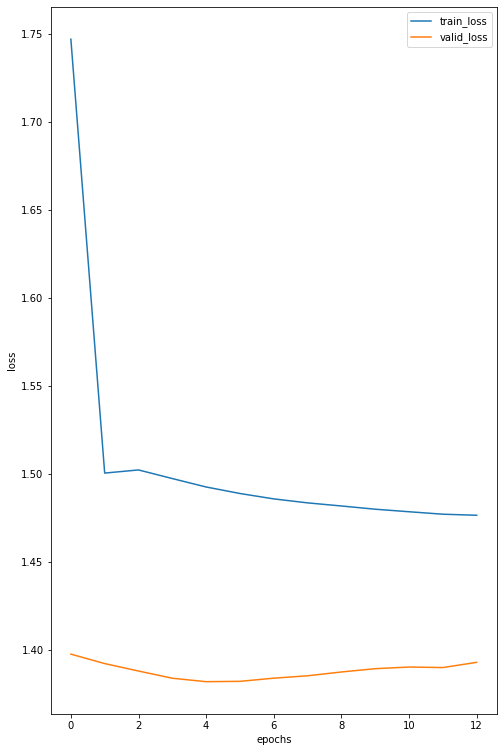

In [ ]:

plot_train_valid_loss(train_loss, valid_loss)

MannwhitneyuResult(statistic=81626.0, pvalue=0.03077180313039602)


(1.3816576858116951, 0.012027260240867088)

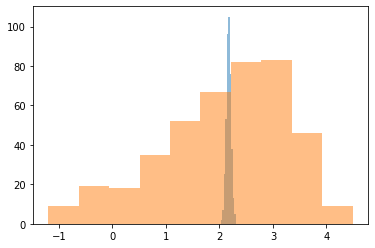

In [ ]:
test_calculat(model, torch.tensor(X_test), y_test.values)

**MSE = 1.45, R2 = -0.04**

Распределения из разных выборок по критерию Манна Уитни отличаются (p < 0.05). То есть, модель не научилась предсказывать растворимость молекул в жирах
